In [1]:
# import os
# os.environ["PYTENSOR_FLAGS"] = "cxx="
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
import pytensor.tensor as pt

plt.rcParams["figure.figsize"] = (12, 4)
az.rcParams["stats.hdi_prob"] = 0.94
print('done')

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


done


c:\Users\Hp\Desktop\brent-oil-change-point-analysis\.venv\Lib\site-packages\arviz\rcparams.py:345: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


In [2]:
df = pd.read_csv("../data/raw/BrentOilPrices.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

df["log_price"] = np.log(df["Price"])
df["log_return"] = df["log_price"].diff()

df = df.dropna(subset=["log_return"]).reset_index(drop=True)
df.head()


C:\Users\Hp\AppData\Local\Temp\ipykernel_4992\1555838161.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


,Date,Price,log_price,log_return
0,1987-05-21,18.45,2.915064,-0.009709
1,1987-05-22,18.55,2.920470,0.005405
2,1987-05-25,18.60,2.923162,0.002692
3,1987-05-26,18.63,2.924773,0.001612
4,1987-05-27,18.60,2.923162,-0.001612


In [3]:
start = pd.Timestamp("2018-01-01")
end = pd.Timestamp("2022-09-30")

df_decade = df[(df["Date"] >= start) & (df["Date"] <= end)].copy().reset_index(drop=True)
r = df_decade["log_return"].values
dates = df_decade["Date"].values

len(r), df_decade["Date"].min(), df_decade["Date"].max()


(1208, Timestamp('2018-01-02 00:00:00'), Timestamp('2022-09-30 00:00:00'))

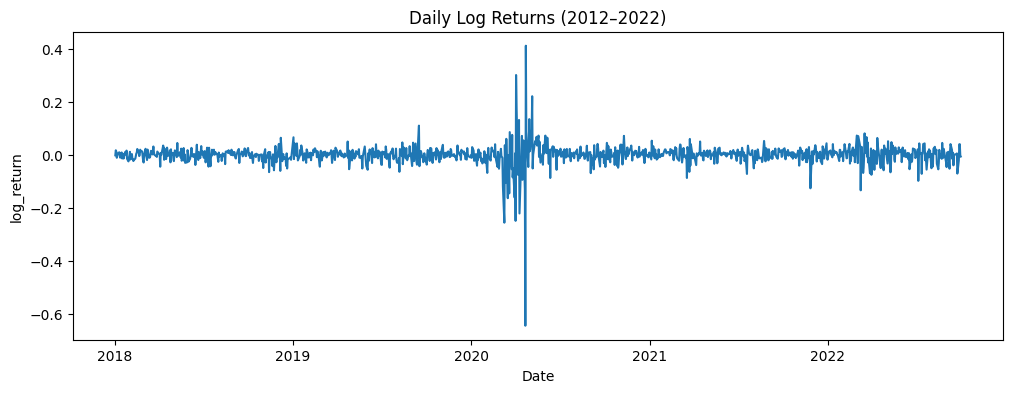

In [4]:
plt.figure()
plt.plot(df_decade["Date"], r)
plt.title("Daily Log Returns (2012–2022)")
plt.xlabel("Date")
plt.ylabel("log_return")
plt.show()


In [ ]:
# Standardize returns for better geometry
r_std = (r - r.mean()) / r.std()
T = len(r_std)
t = np.arange(T)

with pm.Model() as soft_cp_fast:
    tau = pm.Uniform("tau", lower=0, upper=T-1)

    mu1 = pm.Normal("mu1", 0.0, 1.0)
    mu2 = pm.Normal("mu2", 0.0, 1.0)
    sigma = pm.HalfNormal("sigma", 1.0)

    k = 0.1  # fixed smoothness (do NOT sample k)
    w = pm.math.sigmoid(k * (t - tau))
    mu_t = (1 - w) * mu1 + w * mu2

    obs = pm.Normal("obs", mu=mu_t, sigma=sigma, observed=r_std)

    idata_soft = pm.sample(
        draws=250,
        tune=250,
        chains=1,
        cores=1,
        target_accept=0.9,
        random_seed=42,
        idata_kwargs={"log_likelihood": True},
    )


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu1, mu2, sigma]


Output()

c:\Users\Hp\Desktop\brent-oil-change-point-analysis\.venv\Lib\site-packages\pymc\step_methods\hmc\quadpotential.py:
316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)

In [ ]:
az.summary(idata_soft, var_names=["tau", "mu1", "mu2", "sigma"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,498.572,208.687,2.000,722.000,133.316,84.720,3.0,18.0,2.24
mu1,-0.001,0.003,-0.006,0.004,0.001,0.001,7.0,15.0,1.21
mu2,0.002,0.002,-0.002,0.006,0.001,0.000,5.0,155.0,1.32
sigma,0.039,0.001,0.037,0.040,0.000,0.000,837.0,804.0,1.00


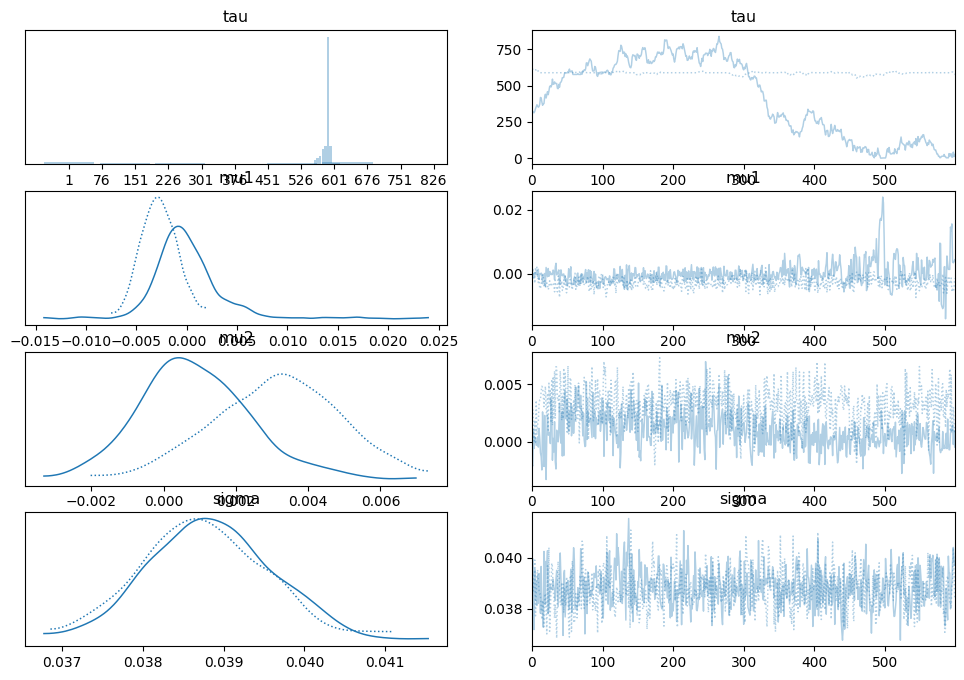

In [ ]:
az.plot_trace(idata_soft, var_names=["tau", "mu1", "mu2", "sigma"])
plt.show()


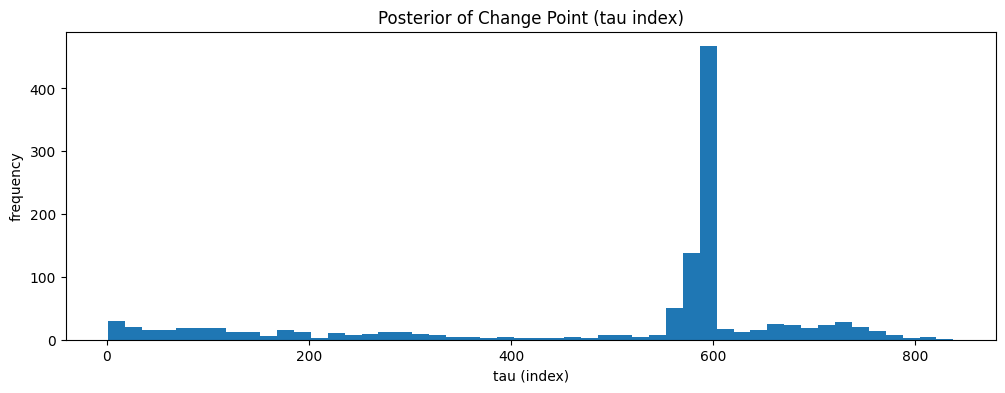

(588,
 Timestamp('2020-04-22 00:00:00'),
 array([  2, 722]),
 (Timestamp('2018-01-04 00:00:00'), Timestamp('2020-10-30 00:00:00')))

In [ ]:
tau_samples = idata_soft.posterior["tau"].values.flatten().astype(int)

plt.figure()
plt.hist(tau_samples, bins=50)
plt.title("Posterior of Change Point (tau index)")
plt.xlabel("tau (index)")
plt.ylabel("frequency")
plt.show()

tau_median = int(np.median(tau_samples))
tau_date = df_decade.loc[tau_median, "Date"]

tau_hdi = az.hdi(tau_samples, hdi_prob=0.94)
tau_hdi_dates = (df_decade.loc[int(tau_hdi[0]), "Date"], df_decade.loc[int(tau_hdi[1]), "Date"])

tau_median, tau_date, tau_hdi, tau_hdi_dates


In [ ]:
mu1_s = idata_soft.posterior["mu1"].values.flatten()
mu2_s = idata_soft.posterior["mu2"].values.flatten()
delta = mu2_s - mu1_s

print("P(mu2 > mu1) =", (delta > 0).mean())
print("Delta mean (mu2-mu1):", np.mean(delta))
print("94% HDI delta:", az.hdi(delta, hdi_prob=0.94))


P(mu2 > mu1) = 0.8083333333333333
Delta mean (mu2-mu1): 0.0033194163274197154
94% HDI delta: [-0.00475745  0.00992898]


In [ ]:
with pm.Model() as model_t:
    tau = pm.DiscreteUniform("tau", lower=0, upper=T-1)

    mu1 = pm.Normal("mu1", mu=0.0, sigma=0.02)
    mu2 = pm.Normal("mu2", mu=0.0, sigma=0.02)

    sigma = pm.HalfNormal("sigma", sigma=0.05)
    nu = pm.Exponential("nu", lam=1/10) + 2  # df > 2

    mu_t = pm.math.switch(pt.arange(T) < tau, mu1, mu2)

    obs = pm.StudentT("obs", nu=nu, mu=mu_t, sigma=sigma, observed=r)

    idata_t = pm.sample(
        draws=300,
        tune=300,
        chains=1,
        cores=1,                 # IMPORTANT on Windows
        target_accept=0.9,
        random_seed=42,          
        idata_kwargs={"log_likelihood": True},
    )

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma, nu]


Output()

Sampling 1 chain for 300 tune and 300 draw iterations (300 + 300 draws total) took 3884 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [ ]:
cmp = az.compare({"Normal": idata_soft, "StudentT": idata_t}, method="BB-pseudo-BMA", ic="waic")
cmp

TypeError: Encountered error in ELPD computation of compare.

In [ ]:
events = pd.read_csv("../data/events/brent_key_events.csv")
events["event_date"] = pd.to_datetime(events["event_date"])

tau_date = pd.Timestamp(df_decade.loc[tau_median, "Date"])
events["days_from_tau"] = (events["event_date"] - tau_date).dt.days

events.sort_values("days_from_tau").head(8)[
    ["event_date","event_name","category","days_from_tau","expected_market_channel"]
]
